<a href="https://colab.research.google.com/github/Asad1287/50_ML_Projects_50_Days/blob/main/Day2_GenerativeSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose of Notebook 2: Probability & Sampling

The primary purpose of this notebook is to build a solid foundation in understanding probability distributions and sampling techniques, which are essential for generative modeling. Generative models, such as GANs, VAEs, and Diffusion Models, rely on the ability to sample data from learned distributions to generate new outputs. Therefore, developing intuition around how data is represented, sampled, and approximated is a crucial first step in learning generative AI.

This notebook introduces two fundamental distributions: the Gaussian (Normal) distribution, which is central to many generative models due to its natural occurrence in data, and the Uniform distribution, often used as a baseline or proposal distribution in sampling techniques. Learners will implement basic sampling from these distributions and visualize the results to understand how empirical data (generated samples) compares to theoretical probability distributions. This exercise helps to solidify their grasp of how distributions underpin the process of generating data.

The notebook also explores two essential sampling techniques: importance sampling and rejection sampling, which are used to estimate properties of a complex target distribution using simpler distributions. Importance sampling introduces the concept of weighted sampling, while rejection sampling teaches how to generate data by accepting or rejecting samples based on probabilities. Both techniques provide a practical framework for working with distributions that are difficult to sample from directly.

By the end of this notebook, learners will have a strong understanding of how data sampling works, how distributions behave, and why these concepts are critical in generative models. They will also gain hands-on experience in implementing and visualizing these methods, laying the groundwork for more advanced topics like latent spaces, adversarial training, and diffusion processes

True mean: 0.577350
Estimated mean: 0.573937
Absolute error: 0.003413


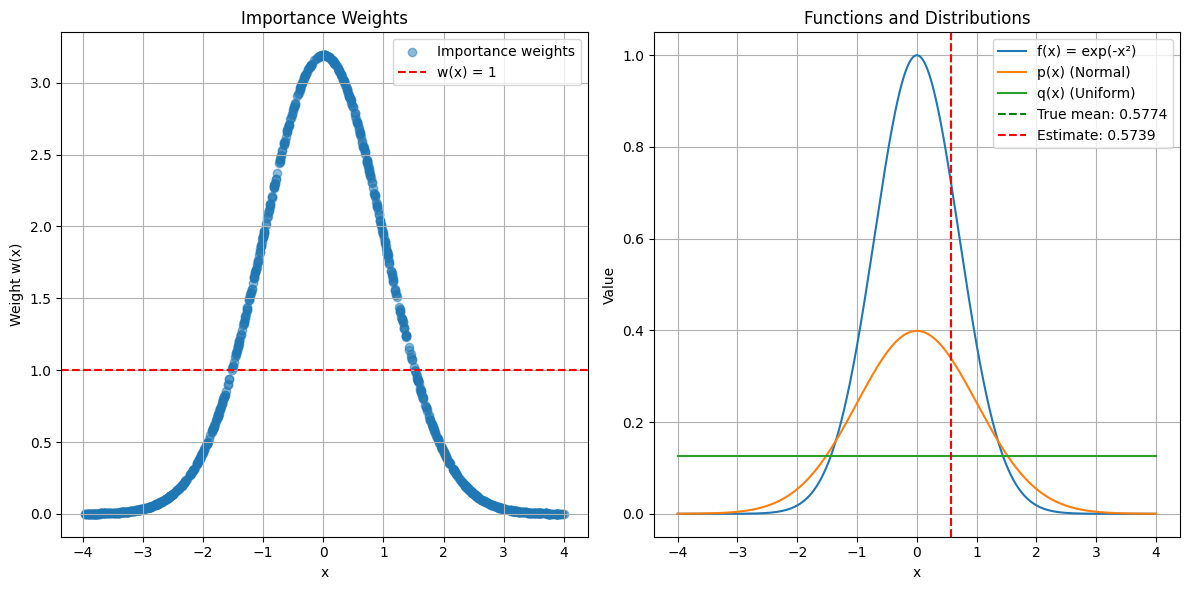

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def f(x):
    """Target function f(x) = exp(-x^2)"""
    return np.exp(-x**2)

def p(x):
    """Target distribution (standard normal)"""
    return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)

def q(x):
    """Proposal distribution (uniform)"""
    # Uniform distribution over [-4, 4]
    return np.where((x >= -4) & (x <= 4), 1/8, 0)

def importance_sampling(n_samples):
    """
    Perform importance sampling

    Parameters:
    n_samples (int): Number of samples to draw

    Returns:
    float: Estimated mean
    array: Samples
    array: Weights
    """
    # Draw samples from proposal distribution (uniform)
    samples = np.random.uniform(-4, 4, n_samples)

    # Calculate importance weights
    weights = p(samples) / q(samples)

    # Calculate weighted function values
    f_values = f(samples)

    # Compute weighted mean
    estimate = np.sum(weights * f_values) / np.sum(weights)

    return estimate, samples, weights

def compute_true_mean():
    """Compute the true mean using numerical integration"""
    # Integrate f(x)p(x) over (-inf, inf)
    result, _ = integrate.quad(lambda x: f(x) * p(x), -np.inf, np.inf)
    return result

def plot_results(samples, weights, true_mean, estimate):
    """Plot the results of importance sampling"""
    plt.figure(figsize=(12, 6))

    # Plot 1: Samples and weights
    plt.subplot(1, 2, 1)
    plt.scatter(samples, weights, alpha=0.5, label='Importance weights')
    plt.axhline(y=1, color='r', linestyle='--', label='w(x) = 1')
    plt.xlabel('x')
    plt.ylabel('Weight w(x)')
    plt.title('Importance Weights')
    plt.legend()
    plt.grid(True)

    # Plot 2: Target function and distributions
    x = np.linspace(-4, 4, 1000)
    plt.subplot(1, 2, 2)
    plt.plot(x, f(x), label='f(x) = exp(-x²)')
    plt.plot(x, p(x), label='p(x) (Normal)')
    plt.plot(x, q(x), label='q(x) (Uniform)')
    plt.axvline(x=true_mean, color='g', linestyle='--', label=f'True mean: {true_mean:.4f}')
    plt.axvline(x=estimate, color='r', linestyle='--', label=f'Estimate: {estimate:.4f}')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Functions and Distributions')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Set random seed for reproducibility
    np.random.seed(42)

    # Number of samples
    n_samples = 1000

    # Perform importance sampling
    estimate, samples, weights = importance_sampling(n_samples)

    # Compute true mean
    true_mean = compute_true_mean()

    # Print results
    print(f"True mean: {true_mean:.6f}")
    print(f"Estimated mean: {estimate:.6f}")
    print(f"Absolute error: {abs(true_mean - estimate):.6f}")

    # Plot results
    plot_results(samples, weights, true_mean, estimate)

if __name__ == "__main__":
    main()

Acceptance rate: 64.83%
Time taken: 0.40 seconds
Sample statistics:
  Mean: 0.0134 (should be close to 0)
  Std: 1.5129 (should be close to 1)


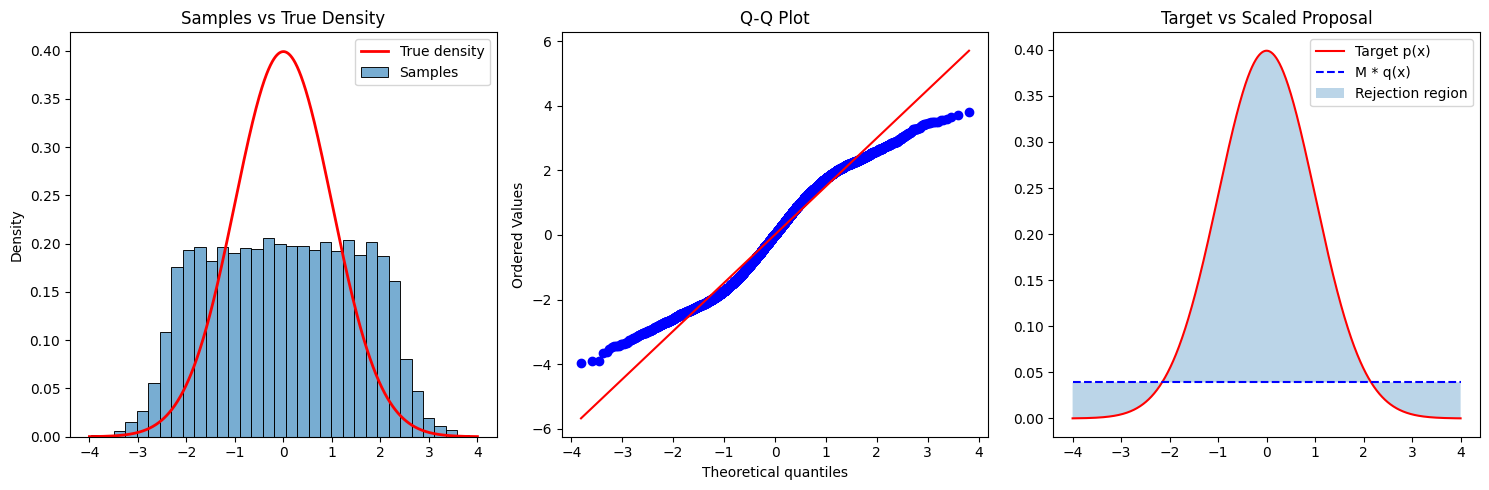

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

class RejectionSampler:
    def __init__(self, xmin=-4, xmax=4):
        """
        Initialize the rejection sampler

        Parameters:
        xmin (float): Lower bound of uniform proposal
        xmax (float): Upper bound of uniform proposal
        """
        self.xmin = xmin
        self.xmax = xmax

        # Target distribution (Gaussian)
        self.p = lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

        # Proposal distribution (Uniform)
        self.q = lambda x: 1 / (xmax - xmin)  # Uniform in [xmin, xmax]

        # Compute optimal scaling factor M
        # M must satisfy p(x) ≤ M * q(x) for all x
        self.M = np.sqrt(2 * np.pi) / (xmax - xmin)

    def sample(self, num_samples):
        """
        Generate samples using rejection sampling

        Parameters:
        num_samples (int): Number of samples to generate

        Returns:
        tuple: (samples, acceptance_rate, time_taken)
        """
        samples = []
        total_attempts = 0
        start_time = time()

        while len(samples) < num_samples:
            # Generate proposal sample
            x = np.random.uniform(low=self.xmin, high=self.xmax)

            # Generate uniform random number for acceptance test
            u = np.random.uniform(low=0, high=1)

            # Accept/reject step
            if u <= self.p(x) / (self.M * self.q(x)):
                samples.append(x)

            total_attempts += 1

        time_taken = time() - start_time
        acceptance_rate = num_samples / total_attempts

        return np.array(samples), acceptance_rate, time_taken

def plot_sampling_results(sampler, samples, acceptance_rate, time_taken):
    """Plot the results of rejection sampling"""
    plt.figure(figsize=(15, 5))

    # Plot 1: Histogram of samples with true density
    plt.subplot(1, 3, 1)
    x = np.linspace(sampler.xmin, sampler.xmax, 1000)
    plt.plot(x, sampler.p(x), 'r-', lw=2, label='True density')
    sns.histplot(samples, stat='density', alpha=0.6, label='Samples')
    plt.title('Samples vs True Density')
    plt.legend()

    # Plot 2: QQ plot
    plt.subplot(1, 3, 2)
    from scipy import stats
    stats.probplot(samples, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    # Plot 3: Target vs Proposal
    plt.subplot(1, 3, 3)
    x = np.linspace(sampler.xmin, sampler.xmax, 1000)
    plt.plot(x, sampler.p(x), 'r-', label='Target p(x)')
    plt.plot(x, sampler.M * sampler.q(x) * np.ones_like(x), 'b--',
             label='M * q(x)')
    plt.fill_between(x, sampler.p(x),
                    sampler.M * sampler.q(x) * np.ones_like(x),
                    alpha=0.3, label='Rejection region')
    plt.title('Target vs Scaled Proposal')
    plt.legend()

    plt.tight_layout()

    # Print statistics
    print(f"Acceptance rate: {acceptance_rate:.2%}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Sample statistics:")
    print(f"  Mean: {np.mean(samples):.4f} (should be close to 0)")
    print(f"  Std: {np.std(samples):.4f} (should be close to 1)")

def main():
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create sampler
    sampler = RejectionSampler()

    # Generate samples
    num_samples = 10000
    samples, acceptance_rate, time_taken = sampler.sample(num_samples)

    # Plot results
    plot_sampling_results(sampler, samples, acceptance_rate, time_taken)
    plt.show()

if __name__ == "__main__":
    main()